In [1]:
import os
os.environ['SPS_HOME'] = "/home/kings/prospector/Enso/fsps"
import toolbox_prospector as tools
import matplotlib.pyplot as plt
import math
import pandas as pd

from prospect.observation import Photometry, Lines


import fsps
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

%matplotlib inline

import prospect.io.read_results as reader

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 20})
rcParams.update({'axes.titlesize': 15})


import fsps
import sedpy
import prospect


import emcee
import dynesty

from astropy import cosmology
cosmo = cosmology.FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.726)
from astropy.table import Table

from astropy.io import fits

from prospect.models.sedmodel import SpecModel
from sedpy.observate import load_filters

SFH_dict = {}

In [3]:
component = 0
output_file = '{}_prospector_test_run_enso_mcmc.h5'.format(component)
if component == 0:
    cname = 'Core'
    cmap = 'darkred'
    cmap2 = 'lightcoral'
elif component == 1:
    cname = 'Point Source'
    cmap = 'mediumvioletred'
    cmap2 = 'pink'
elif component == 2:
    cname = 'Minor Clump'
    cmap = 'steelblue'
    cmap2 = 'lightskyblue'
elif component == 3:
    cname = 'Major Clump'
    cmap = 'darkblue'
    cmap2 = 'royalblue'
# object_id = 74
# # object_id = str(output_file).split('_')[1]
# print('Object ID:', object_id)
# master_cat_file = "congress_Ha_cat"
# el_table_file= 'v092_gdn_new-lsf-flux.dat' #'jades_fresco_spec-z_catalog_v2.4_new-lsf-flux.dat'#"v092_gdn_new-lsf-flux.dat"
# phot_table_file= "gdn_phot_cat.v0.9.2.fits" #phot_cat.goodss.v0.9.5.fits" #"gdn_phot_cat.v0.9.2.fits"

In [4]:
output_path = "/home/kings/prospector/Enso/runs/runs/" + output_file

In [5]:
# paths

path_wdir = "/home/kings/prospector/Enso/"
# path_cats = os.path.join(path_wdir, "catalogs")


In [6]:

# define dicts - DATA

def build_obs(component, err_floor=0.05, err_floor_el=0.05, **kwargs):
    """Build a dictionary of observational data. 
    
    :param snr:
        The S/N to assign to the photometry, since none are reported 
        in Johnson et al. 2013
        
    :param ldist:
        The luminosity distance to assume for translating absolute magnitudes 
        into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """

    # from prospect.utils.obsutils import fix_obs # OUTDATED


    obs = {}

    filter_list = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F277W", "F356W", "F410M", "F444W"]
    obs_filters = sedpy.observate.load_filters(["jwst_" + f.lower() for f in filter_list])
    obs["filters"] = obs_filters


    z_spec = 5.3861

    # Now we store the measured fluxes for each filter, and their uncertainties.
### Server side fluxes ###
    # df = pd.read_csv("/home/kkingsley/enso/4compSVI_fluxes_nJy.csv")
### Local fluxes ###
    df = pd.read_csv("/home/kings/prospector/Enso/data/4compSVI_fluxes_nJy.csv")


## Component 0 Fluxes: ##
    # load in fluxes, convert to Jy then magggies
    flux_index = 'flux_{}s'.format(component)
    lower_index = 'flux_{}s_delta_lower'.format(component)
    upper_index = 'flux_{}s_delta_upper'.format(component)

    maggies = df[flux_index].to_numpy() * 1e-9 / 3631
    obs["maggies"] = maggies

    # creating uncertainties from upper and lower errors
    f0u_l = df[lower_index].to_numpy() * 1e-9 / 3631
    f0u_u = (df[upper_index]).to_numpy() * 1e-9 / 3631
    lbound = maggies - f0u_l
    ubound = maggies + f0u_u

    flux_unc = (ubound - lbound) / 2

    # And now we store the uncertainties (again in units of maggies)
    maggies_unc = np.array(flux_unc)
    obs["maggies_unc"] = maggies_unc

    print("###############################\n")
    print("Component: {}.\nMaggies: {}.\nUncertainties: {}.".format(component, maggies, maggies_unc))
    print("###############################")


## Build rest of obs dict ##
    # Now we need a mask, which says which flux values to consider in the likelihood.
    phot_mask = np.array([obs["filters"]])
    # obs["phot_mask"] = phot_mask
    obs["phot_mask"] = None

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    # (this would be a vector of vacuum wavelengths in angstroms)
    obs["wavelength"] = None
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = None
    # (spectral uncertainties are given here)
    obs['unc'] = None
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    obs['mask'] = None

    obs_wave_eff = [f.wave_effective for f in obs_filters]

    pdat = Photometry(
            filters =   obs_filters,
            flux =   maggies,
            uncertainty = maggies_unc,
            mask    =   np.isfinite(maggies) #phot_mask & (np.array(obs_wave_eff) > ((z_spec + 1) * 912))
                    )
    
    # sdat = Spectrum()
    # sdat.rectify()
    pdat.rectify()

    return [pdat] #, sdat]

# --------------
# Model Definition 
# --------------

def build_model(object_redshift=5.3861, sfh_template="continuity_sfh", nbins_sfh=8, student_t_width=0.3, z_limit_sfh=20.0, 
                add_IGM_model=False, add_duste=False, add_agn=False, add_neb=False, **extras):
    """
    Construct a model.
    sfh_template : "continuity_sfh", "dirichlet_sfh", "parametric_sfh"

    """
    from prospect.models.templates import TemplateLibrary, adjust_continuity_agebins, adjust_dirichlet_agebins
    from prospect.models import priors, sedmodel
    from prospect.models import transforms
    # from prospect.models.sedmodel import SedModel


    # get SFH template
    if (sfh_template == "continuity_sfh"):
        model_params = TemplateLibrary["continuity_sfh"]
    elif (sfh_template == "dirichlet_sfh"):
        model_params = TemplateLibrary["dirichlet_sfh"]
    elif (sfh_template == "parametric_sfh"):
        model_params = TemplateLibrary["parametric_sfh"]

    # IMF: 0: Salpeter (1955); 1: Chabrier (2003); 2: Kroupa (2001)
    model_params['imf_type']['init'] = 1

    # fit for redshift
    model_params["zred"]['isfree'] = False
    
    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    # add redshift scaling to agebins, such that
    def zred_to_agebins(zred=model_params["zred"]["init"], agebins=None, z_limit_sfh=20.0, nbins_sfh=8, **extras):
        tuniv = cosmo.age(zred).value*1e9
        tbinmax = tuniv-cosmo.age(z_limit_sfh).value*1e9
        # tbinmax = tuniv*0.95
        agelims = np.append(np.array([0.0, 6.7, 7.0, 7.4772]), np.linspace(7.4772, np.log10(tbinmax), int(nbins_sfh-2))[1:])
        agebins = np.array([agelims[:-1], agelims[1:]])
        return agebins.T

    def logmass_to_masses(logmass=None, logsfr_ratios=None, zred=model_params["zred"]["init"], nbins_sfh=8, z_limit_sfh=None, **extras):
        agebins = zred_to_agebins(zred=zred, nbins_sfh=nbins_sfh)
        logsfr_ratios = np.clip(logsfr_ratios, -10, 10)  # numerical issues...
        nbins = agebins.shape[0]
        sratios = 10**logsfr_ratios
        dt = (10**agebins[:, 1]-10**agebins[:, 0])
        coeffs = np.array([(1./np.prod(sratios[:i])) * (np.prod(dt[1:i+1]) / np.prod(dt[:i])) for i in range(nbins)])
        m1 = (10**logmass) / coeffs.sum()
        return m1 * coeffs

    if (sfh_template == "continuity_sfh"):
        # adjust number of bins for SFH and prior
        model_params['agebins']['N'] = nbins_sfh
        model_params['mass']['N'] = nbins_sfh
        model_params['logsfr_ratios']['N'] = nbins_sfh-1
        model_params['logsfr_ratios']['init'] = np.full(nbins_sfh-1, 0.0)  # constant SFH
        model_params['logsfr_ratios']['prior'] = priors.StudentT(mean=np.full(nbins_sfh-1, 0.0), scale=np.full(nbins_sfh-1, student_t_width), df=np.full(nbins_sfh-1, 2))
        model_params['agebins']['depends_on'] = zred_to_agebins
        # set mass prior
        model_params["logmass"]["prior"] = priors.TopHat(mini=6, maxi=12)
        model_params['mass']['depends_on'] = logmass_to_masses

    elif (sfh_template == "dirichlet_sfh"):
        tuniv = cosmo.age(model_params["zred"]["init"]).value*1e9
        tbinmax = tuniv-cosmo.age(z_limit_sfh).value*1e9
        agelims = np.append(np.array([0.0, 6.7, 7.0, 7.4772]), np.linspace(7.4772, np.log10(tbinmax), int(nbins_sfh-2))[1:])
        model_params = adjust_dirichlet_agebins(model_params, agelims=agelims)
        model_params["total_mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e12)

    elif (sfh_template == "parametric_sfh"):
        model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=10)
        model_params["tage"]["prior"] = priors.TopHat(mini=1e-3, maxi=cosmo.age(model_params["zred"]["init"]).value)
        model_params["mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e12)

    # adjust other priors
    model_params["logzsol"]["prior"] = priors.ClippedNormal(mean=-1.0, sigma=0.3, mini=-2.0, maxi=0.19)  # priors.TopHat(mini=-2.0, maxi=0.19)

    # complexify the dust
    model_params['dust_type']['init'] = 4
    model_params["dust2"]["prior"] = priors.ClippedNormal(mini=0.0, maxi=6.0, mean=0.3, sigma=1)
    model_params["dust_index"] = {"N": 1,
                                  "isfree": True,
                                  "init": 0.0, "units": "power-law multiplication of Calzetti",
                                  "prior": priors.TopHat(mini=-1.0, maxi=0.4)}

    def to_dust1(dust1_fraction=None, dust1=None, dust2=None, **extras):
        return(dust1_fraction*dust2)

    model_params['dust1'] = {"N": 1,
                             "isfree": False,
                             'depends_on': to_dust1,
                             "init": 0.0, "units": "optical depth towards young stars",
                             "prior": None}
    model_params['dust1_fraction'] = {'N': 1,
                                      'isfree': True,
                                      'init': 1.0,
                                      'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3)}

    # fit for IGM absorption
    if add_IGM_model:
        model_params.update(TemplateLibrary["igm"])
        model_params["igm_factor"]['isfree'] = True
        model_params["igm_factor"]["prior"] = priors.ClippedNormal(mean=1.0, sigma=0.3, mini=0.0, maxi=2.0)
    else:
        model_params.update(TemplateLibrary["igm"])
        model_params["igm_factor"]['isfree'] = False

    # Change the model parameter specifications based on some keyword arguments
    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        model_params.update(TemplateLibrary["dust_emission"])
        model_params['duste_gamma']['isfree'] = True
        model_params['duste_qpah']['isfree'] = True
        model_params['duste_umin']['isfree'] = True

    if add_agn:
        # Add dust emission (with fixed dust SED parameters)
        model_params.update(TemplateLibrary["agn"])
        model_params['fagn']['isfree'] = True
        model_params['agn_tau']['isfree'] = True

    if add_neb:
        # Add nebular emission (with fixed parameters)
        model_params.update(TemplateLibrary["nebular"])
        model_params['gas_logu']['isfree'] = True
        model_params['gas_logz']['isfree'] = True
        _ = model_params["gas_logz"].pop("depends_on")
        #model_params["gas_logz"]["depends_on"] = transforms.stellar_logzsol

    # if add_eline_scaling:
    #     # Rescaling of emission lines
    #     model_params["linespec_scaling"] = {"N": 1,
    #                                         "isfree": True,
    #                                         "init": 1.0, "units": "multiplative rescaling factor",
    #                                         "prior": priors.ClippedNormal(mean=1.0, sigma=0.3, mini=0.1, maxi=2.0)}

    # Now instantiate the model using this new dictionary of parameter specifications

    model = sedmodel.SpecModel(model_params) #LineSpecModel doesn't exist anymore
    # model.params  # will reflect dependencies after this
    # model.set_parameters(model.rectify_theta(model.theta))
    return model




In [7]:
def build_sps(zcontinuous=1, sfh_template="continuity_sfh", compute_vega_mags=False, **extras):
    if (sfh_template == "continuity_sfh") or (sfh_template == "dirichlet_sfh"):
        from prospect.sources import FastStepBasis
        sps = FastStepBasis(zcontinuous=zcontinuous,
                            compute_vega_mags=compute_vega_mags,
                            reserved_params=['tage', 'sigma_smooth'])
    else:
        from prospect.sources import CSPSpecBasis
        sps = CSPSpecBasis(zcontinuous=zcontinuous,
                           compute_vega_mags=compute_vega_mags,
                           reserved_params=['sigma_smooth'])
    return sps

In [8]:
res, obs, model = reader.results_from(output_path)
# model = build_model(object_redshift=5.3861, nbins_sfh=6, student_t_width=0.5, add_neb=True) 

# model = reader.get_model(res)
model
if model == None:
    print("No model found in file")
    #run_params = res['bestfit']['run_params']
    model = build_model(object_redshift=5.3861, sfh_template="continuity_sfh", nbins_sfh=8, student_t_width=0.3, z_limit_sfh=20.0, 
                add_IGM_model=False, add_duste=False, add_agn=False, add_neb=False, **extras) 

obs = build_obs(component=component, err_floor=0.05, err_floor_el=0.05, incl_hst=False)

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.ClippedNormal'>(mean=-1.0,sigma=0.3,mini=-2.0,maxi=0.19)
  dust2: <class 'prospect.models.priors.ClippedNormal'>(mean=0.3,sigma=1,mini=0.0,maxi=6.0)
  logmass: <class 'prospect.models.priors.TopHat'>(mini=6,maxi=12)
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(mean=[0. 0. 0. 0. 0. 0. 0.],scale=[0.3 0.3 0.3 0.3 0.3 0.3 0.3],df=[2 2 2 2 2 2 2])
  dust_index: <class 'prospect.models.priors.TopHat'>(mini=-1.0,maxi=0.4)
  dust1_fraction: <class 'prospect.models.priors.ClippedNormal'>(mean=1.0,sigma=0.3,mini=0.0,maxi=2.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [5.3861] 
  mass: [1000000.] <function build_model.<locals>.logmass_to_masses at 0x7f80e9352170>
  sfh: [3] 
  imf_type: [1] 
  dust_type: [4] 
  agebins: [[ 0.  8.]
 [ 8.  9.]
 [ 9. 10.]] <function build_model.<locals>.zred_to_agebins at 0x7f80e93520e0>


In [99]:
# sps = reader.get_sps(res)
sps = build_sps(zcontinuous=1, sfh_template="continuity_sfh", compute_vega_mags=False)


In [100]:
output = res
phot, = obs
z_spec = 5.3861
a = 1 + z_spec
# elines = None

In [101]:
wphot = phot.wavelength
wspec = sps.wavelengths
wspec *= a
# # spectroscopic wavelengths
# if elines.wavelength is None:
#     # *restframe* spectral wavelengths, since obs["wavelength"] is None
#     wspec = sps.wavelengths
#     wspec *= a #redshift them
# else:
#     wspec = elines.wavelength     ###

In [102]:
#cgs to janksy: 1e-23
#cgs to nanojanksy: 1e-9*1e-23
cgs_to_jy = 1e23
#maggies to janksy: 3631
jy_to_maggies = (3631)**(-1)

cgs_to_maggies = cgs_to_jy * jy_to_maggies

In [103]:
def fnu2flam(lam,fnu): # fnu in erg/s/cm2/Hz
    c = 2.998e18 #A/s
    flam = c* fnu / lam**2
    return flam

In [104]:
res['weights']
# Normalize weights
def normalise_weights(weights):
    total_weight = np.sum(weights)
    normalised_weights = weights / total_weight
    return normalised_weights
res['weights'] = normalise_weights(res['weights'])

mask = np.array(phot.mask).astype(int)
# theta_best = output['bestfit']['parameter'] ## EMPTY FOR ME
from prospect.utils.stats import get_best
res['parnames'], res['thetamap'] = get_best(res)


res['theta_labels'] = [f"{name}{i+1}" if res['chain'][0][name].size > 1 else name
                       for name in res['chain'][0].dtype.names
                       for i in range(res['chain'][0][name].size)]
# Flatten the chain for analysis
res['bumpychain'] = np.array(res['chain'])
res['chain'] = np.array([np.concatenate([entry[name].flatten() for name in entry.dtype.names])
                         for entry in res['chain']])


# generate model
# prediction = model.mean_model(theta_best, obs=obs, sps=sps) #model.predict and change obs - observations
prediction = model.predict(res['thetamap'], observations=obs, sps=sps)
print(prediction)
pphot = prediction[0][0]
pfrac = prediction[1]
print(pfrac)
# pspec = np.array(pspec)
pphot = np.array(pphot)
wphot = np.array(wphot)


([array([3.38729931e-11, 5.12827939e-11, 6.62480754e-11, 9.96789595e-11,
       1.14363330e-10, 1.26024698e-10, 2.82654815e-10, 3.30594681e-10,
       4.79328975e-10, 4.27897334e-10])], np.float64(0.7010098960916139))
0.7010098960916139


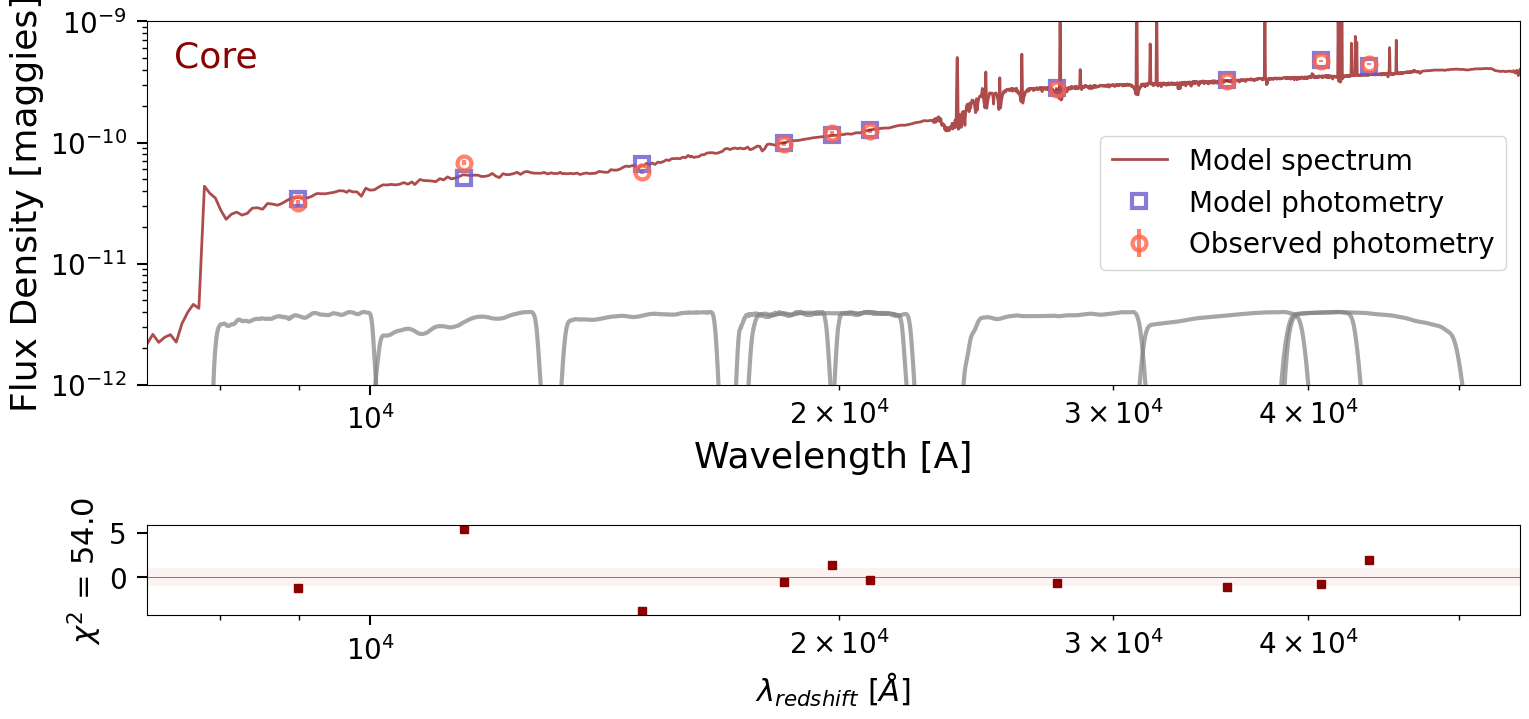

In [ ]:
# cmap = 'mediumvioletred'
# cmap2 = 'mediumvioletred'
size1 = 26
size2 = 22
size3 = 20

f, (ax, chiax) = subplots(2,1, gridspec_kw={'height_ratios': [12, 3]}, figsize=(16,8))

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
# temp = np.interp(np.linspace(xmin,xmax,10000), wspec, pphot)
# ymin, ymax = temp.min()*0.8, temp.max()/0.4
ymin, ymax = 10e-13, 10e-10

# plot Data, best fit model
# loglog(wspec, pspec, label='Model spectrum', 
#        lw=0.7, color='slateblue', alpha=0.7)

#only plot non-masked photometry
wphot_mask = wphot[phot.mask]
pphot_mask = pphot[phot.mask]
obs_phot_mask = phot.flux[mask==1]
obs_phot_unc_mask = phot.uncertainty[mask==1]
xmin, xmax = np.min(wphot_mask)*0.8, np.max(wphot_mask)/0.8

ax.errorbar(wphot_mask, pphot_mask, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
ax.errorbar(wphot_mask, obs_phot_mask, yerr=obs_phot_unc_mask,
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# Insert component name
ax.text(0.02, 0.95, cname, transform=ax.transAxes, fontsize=26,
        verticalalignment='top', horizontalalignment='left', color=cmap)

#get zspec for the object
# el_data = Table.read(os.path.join(path_cats, el_table_file), format="ascii")
# idx_gal = int(object_id) - 1
# master_cat = Table.read(os.path.join(path_cats, master_cat_file), format="ascii")
# ID = int(master_cat[idx_gal]['ID'])
# idx_el = (el_data['ID'] == ID)
# z_spec = el_data[idx_el]['zspec'][0]
z_spec = 5.3861

a = 1.0 + z_spec
x   =  sps.wavelengths *a # restframe lambda times redshift
# y   =   fnu2flam(x,model._norm_spec*3631*1e-23)
# spectrum = model._norm_spec[np.where((x > xmin) & (x < xmax))]
ax.loglog(x, model._norm_spec, label='Model spectrum', lw=2, color=cmap, alpha=0.7)

# plot filter transmission curves
for f in phot.filters:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    ax.loglog(w, t, lw=3, color='gray', alpha=0.7)
# ax.set_xscale('log')

# Prettify
ax.set_xlabel('Wavelength [A]', fontsize=size1)
ax.set_ylabel('Flux Density [maggies]', fontsize=size1)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
# suptitle('galaxy id: ' + str(ID)) ##
ax.legend(loc='best', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=size3)
ax.tick_params(axis='both', which='minor', labelsize=size3)


#plot the chi2
# --------------------------- Plot the weighted residuals (pull) under the spectrum -------------------------------
imax = np.argmax(res['lnprobability'])
map_parameter_vector    =   res["chain"][imax]
chi_square  = np.nansum((obs_phot_mask - pphot_mask)**2 / obs_phot_unc_mask**2)  #/(obs_phot_mask+len(elines.flux) - len(map_parameter_vector))
pull        =   (obs_phot_mask - pphot_mask) / obs_phot_unc_mask
chiax.axhline(y=0, color='red', linestyle='-', lw=0.5)
chiax.axhspan(-1,1, color=cmap2, alpha=0.1, lw=0)
chiax.plot(wphot_mask,pull,'s', label='Model photometry',color=cmap)
chiax.set_ylabel('$\chi^2$ = '+str(np.round(np.sum(chi_square), 2)), size=size2)
chiax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
chiax.set_xlabel(r'$\lambda_{redshift}$ [$\AA$]',size=size2)
chiax.set_xlim([xmin, xmax])
chiax.set_xscale('log')
tight_layout()

chiax.tick_params(axis='both', which='major', labelsize=size3)
chiax.tick_params(axis='both', which='minor', labelsize=size3)

# savefig(path_wdir + '/plots/'+ output_file.split('.')[0] + '_photometry_fit')

In [108]:
#split the full list of params that are being fit for into 2

pars_1 = ['logzsol', 'logmass','logsfr_ratios_1', 'logsfr_ratios_2', 'logsfr_ratios_3', 'logsfr_ratios_4', 'logsfr_ratios_5']
pars_2 = ['dust2', 'dust_index', 'dust1_fraction', 'gas_logz', 'gas_logu'] #, 'linespec_scaling']

In [109]:
# theta_best = res['thetamap']
# theta_best1 = [theta_best[0], theta_best[2], theta_best[3], theta_best[4], theta_best[5] , theta_best[6] , theta_best[7]]
# theta_best2 = [theta_best[1],theta_best[8], theta_best[9], theta_best[10], theta_best[11], theta_best[12]]

# weights1 = [res['weights'][0], res['weights'][2], res['weights'][3], res['weights'][4], res['weights'][5], res['weights'][6], res['weights'][7]]
# weights2 = [res['weights'][1], res['weights'][8], res['weights'][9], res['weights'][10], res['weights'][11], res['weights'][12]]

indices1 = [0, 2, 3, 4, 5, 6, 7]
indices2 = [1, 8, 9, 10, 11] #, 12]

# #get the full list by combining the two lists
# full_names = ['logzsol', 'dust2', 'logmass','logsfr_ratios_1', 'logsfr_ratios_2', 'logsfr_ratios_3', 'logsfr_ratios_4', 'logsfr_ratios_5', 'dust_index', 'dust1_fraction', 'gas_logz', 'gas_logu', 'linespec_scaling']
# full_names = np.array(full_names)   


In [110]:
from prospect.plotting import corner

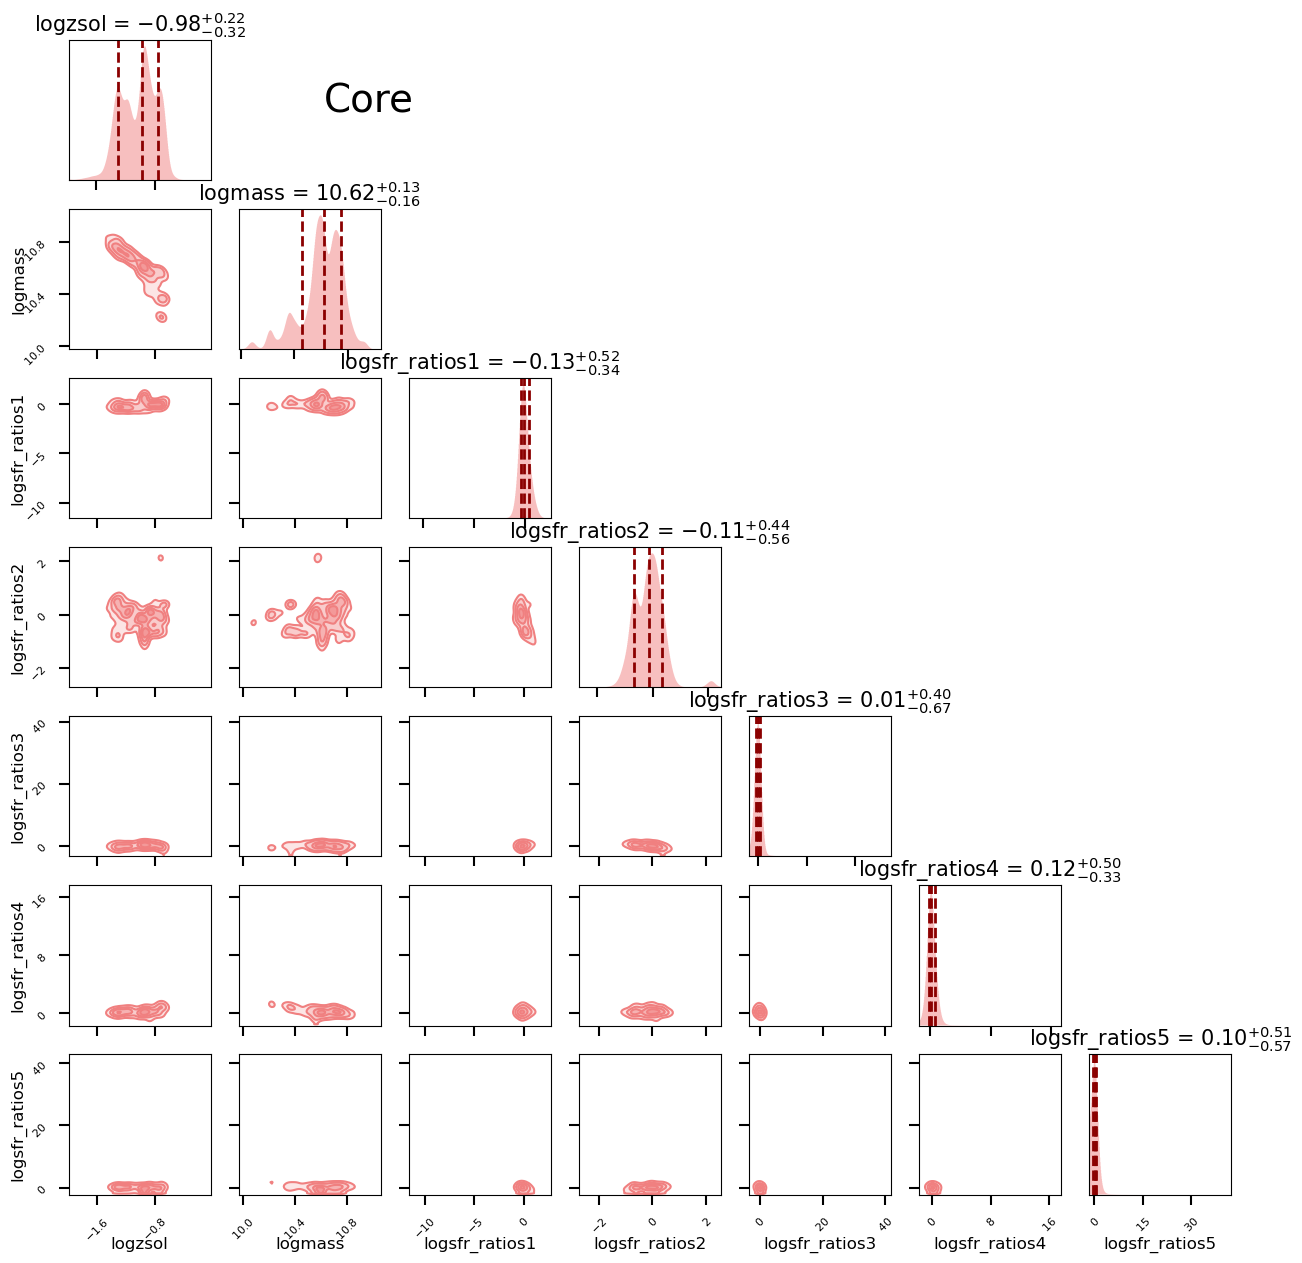

In [ ]:
fig, axes = subplots(7, 7, figsize=(15, 15))
res1 = np.array([res['chain'].T[i] for i in indices1])
labels1 = np.array([res['theta_labels'][i] for i in indices1])
axes[0, 0].text(1.8, 0.7, cname, transform=axes[0, 0].transAxes,
                fontsize=28, verticalalignment='top')
# plt.text(20,25, "0.4''", color='white', fontsize=13)
axes = corner.allcorner(res1, labels1, axes, weights=res['weights'], color=cmap2, qcolor = cmap, show_titles=True)
# suptitle(cname)
# savefig(path_wdir + '/plots/' + output_file.split('.')[0] + '_corner1')

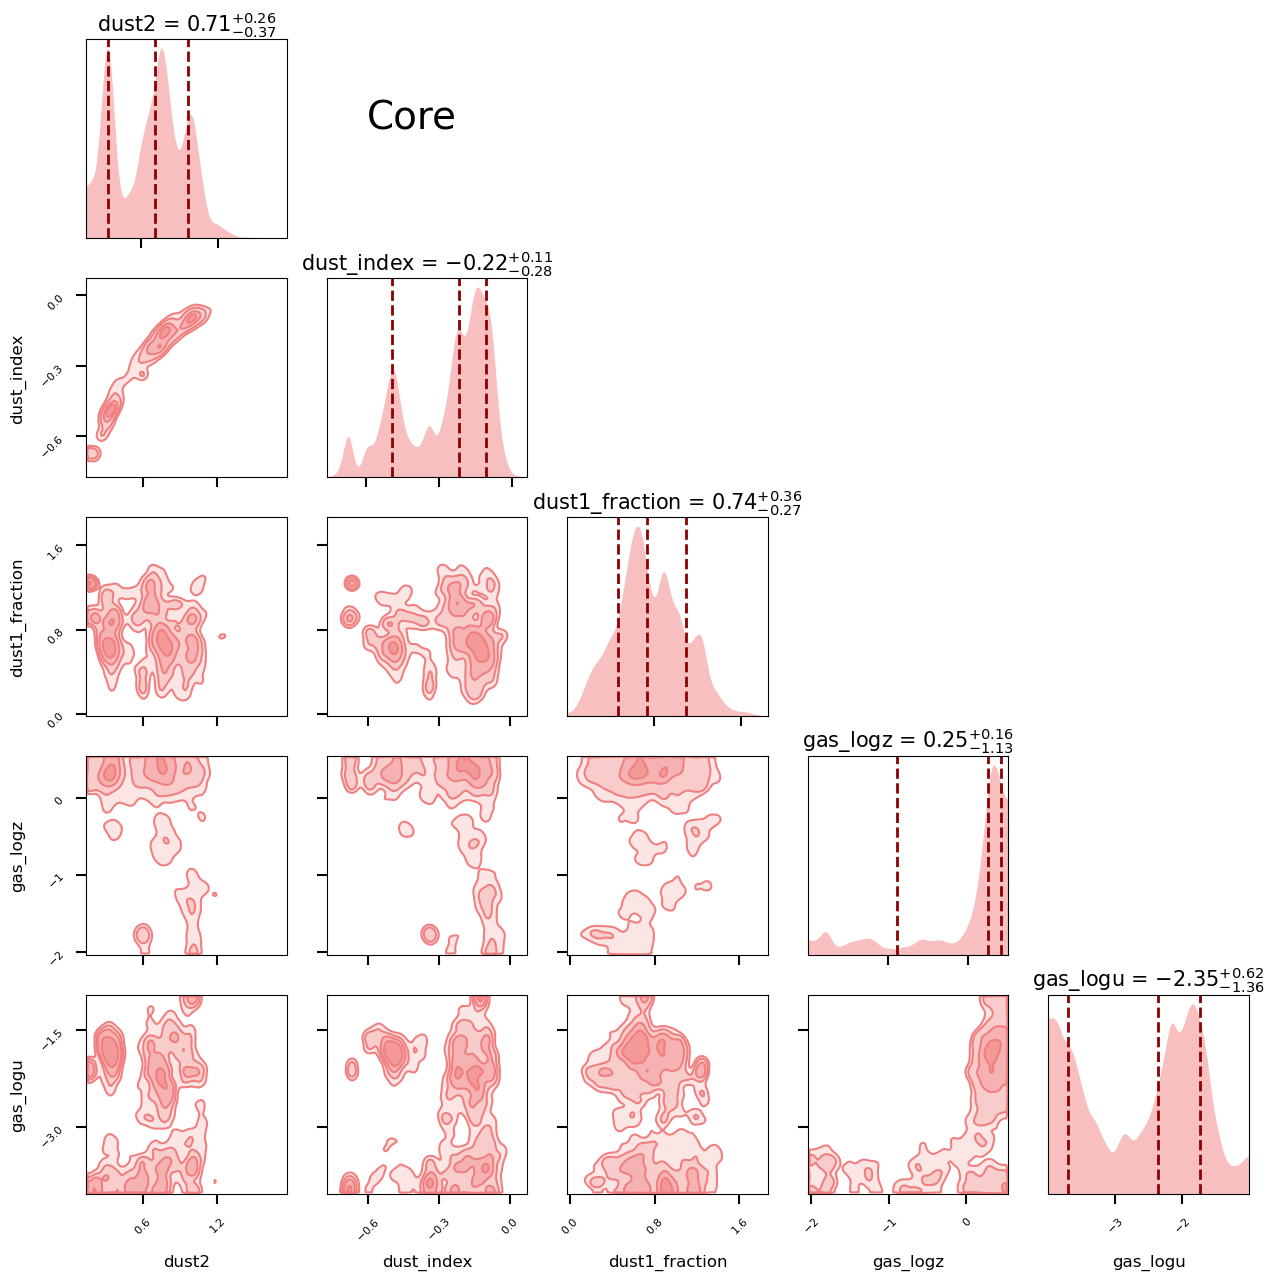

In [139]:
fig,axes = subplots(5,5, figsize=(15,15))
res2 = np.array([res['chain'].T[i] for i in indices2])
labels2 = np.array([res['theta_labels'][i] for i in indices2])
axes[0, 0].text(1.4, 0.7, cname, transform=axes[0, 0].transAxes,
                fontsize=28, verticalalignment='top')
axes = corner.allcorner(res2, labels2, axes, weights=res['weights'], color=cmap2, qcolor = cmap, show_titles=True)
# suptitle(cname)
savefig(path_wdir + '/plots/' + output_file.split('.')[0] + '_corner2')

In [140]:
medians = np.array([np.percentile(res['chain'].T[i], 50, weights=res['weights'], method = 'inverted_cdf') for i in range(len(res['theta_labels']))])


In [141]:
#compute SFRs
# spec, phot, sm = model.predict(theta_best, obs, sps=sps)
prediction = model.predict(res['thetamap'], observations=obs, sps=sps)
# spec = prediction[0][1]
phot = prediction[0][0]
sm = prediction[1]
sfh_params = tools.find_sfh_params(model, res['thetamap'], obs, sps, sm)



sfh_params['sfh'] = -1 #bc non parametric

sfr_5_Myr = tools.calculate_sfr(sfh_params, 0.005,  minsfr=-np.inf, maxsfr=np.inf)
#sfr_10 is traced by Halpha => younger stars
#sfr_100 is traced by UV => older stars
sfr_10_Myr = tools.calculate_sfr(sfh_params, 0.01,  minsfr=-np.inf, maxsfr=np.inf)
sfr_50_Myr = tools.calculate_sfr(sfh_params, 0.05,  minsfr=-np.inf, maxsfr=np.inf)
sfr_100_Myr = tools.calculate_sfr(sfh_params, 0.1,  minsfr=-np.inf, maxsfr=np.inf)
sfr_2000_Myr = tools.calculate_sfr(sfh_params, 2,  minsfr=-np.inf, maxsfr=np.inf)

print('SFR 5 Myr: ', sfr_5_Myr, ' M_sun/yr')
print('SFR 10 Myr: ', sfr_10_Myr, ' M_sun/yr')
print('SFR 50 Myr: ', sfr_50_Myr, ' M_sun/yr')
print('SFR 100 Myr: ', sfr_100_Myr, ' M_sun/yr')
print('SFR 2000 Myr: ', sfr_2000_Myr, ' M_sun/yr')



SFR 5 Myr:  29.552287044752717  M_sun/yr
SFR 10 Myr:  27.155582370037816  M_sun/yr
SFR 50 Myr:  23.404641708250157  M_sun/yr
SFR 100 Myr:  25.30111757662334  M_sun/yr
SFR 2000 Myr:  19.117249544375273  M_sun/yr


In [142]:
stellar_mass = sfh_params['mass']
mass_formed = sfh_params['mformed']

print('Log Stellar Mass: ', math.log10(stellar_mass), ' M_sun')
print('Log Mass Formed: ', math.log10(mass_formed), ' M_sun')
print('sm factor: ', sm)


Log Stellar Mass:  10.42817955376279  M_sun
Log Mass Formed:  10.58245540485798  M_sun
sm factor:  0.7010098960916139


In [143]:
#compute specific star formation rates = if the galaxy was consistenly forming stard at the given sfr,
#the ssfr tells you how many years it would take for it to build up its current stellar mass
ssfr_5_Myr = sfr_5_Myr / stellar_mass
print('sSFR 5 Myr: ', ssfr_5_Myr, ' yr-1 => ' ,1/ssfr_5_Myr/1e6, 'Myr')
ssfr_10_Myr = sfr_10_Myr / stellar_mass
print('sSFR 10 Myr: ', ssfr_10_Myr, ' yr-1 =>', 1/ssfr_10_Myr/1e6, 'Myr')
ssfr_50_Myr = sfr_50_Myr / stellar_mass
print('sSFR 50 Myr: ', ssfr_50_Myr, ' yr-1 =>', 1/ssfr_50_Myr/1e6, 'Myr')
ssfr_100_Myr = sfr_100_Myr / stellar_mass
print('sSFR 100 Myr: ', ssfr_100_Myr, ' yr-1 =>', 1/ssfr_100_Myr/1e6, 'Myr')
ssfr_2000_Myr = sfr_2000_Myr / stellar_mass
print('sSFR 2000 Myr: ', ssfr_2000_Myr, ' yr-1 =>' , 1/ssfr_2000_Myr/1e6, 'Myr')



sSFR 5 Myr:  1.1025836362498007e-09  yr-1 =>  906.9606759277539 Myr
sSFR 10 Myr:  1.0131635737259677e-09  yr-1 => 987.0074546032504 Myr
sSFR 50 Myr:  8.732175252875472e-10  yr-1 => 1145.1900254414888 Myr
sSFR 100 Myr:  9.439742574431448e-10  yr-1 => 1059.3509220353178 Myr
sSFR 2000 Myr:  7.13256692648253e-10  yr-1 => 1402.0197921832278 Myr


In [144]:
from dynesty.plotting import _quantile as weighted_quantile
from copy import deepcopy

time_bins_sfh=np.append(1e-3*np.linspace(0.1, 50.0, num=500), np.logspace(np.log10(0.05), 1.3, num=100)[1:])
ncalc = 1000
nsample = res['chain'].shape[0]
sample_idx = np.random.choice(np.arange(nsample), size=ncalc, p=res['weights'], replace=False)

# fmt = {'chain': np.zeros(shape=ncalc), 'q50': 0.0, 'q84': 0.0, 'q16': 0.0}

# thetas = {}
# parnames = res['theta_labels']
# for i, p in enumerate(parnames):
#     thetas[p] = deepcopy(fmt)
#     thetas[p]['chain'] = res['chain'][sample_idx, i]

sfh_t = time_bins_sfh
shf_chains = {'chain': np.zeros(shape=(ncalc, sfh_t.shape[0])), 'q50': np.zeros(shape=(sfh_t.shape[0])), 'q84': np.zeros(shape=(sfh_t.shape[0])), 'q16': np.zeros(shape=(sfh_t.shape[0]))}

for jj, sidx in enumerate(sample_idx):
    thetas = res['chain'][sidx, :] 
    prediction = model.predict(thetas, obs, sps=sps)
    # spec = prediction[0][1]
    phot = prediction[0][0]
    sm = prediction[1]
    sfh_params = tools.find_sfh_params(model, thetas, obs, sps, sm=sm)
    sfh_params['sfh'] = -1
    shf_chains['chain'][jj, :] = tools.return_full_sfh(sfh_t, sfh_params)
sfh_pdf = np.zeros(shape=(sfh_t.shape[0], 3))
for jj in range(sfh_t.shape[0]):
    sfh_pdf[jj, :] = weighted_quantile(shf_chains['chain'][:, jj], np.array([0.5, 0.16, 0.84]), weights=res['weights'][sample_idx])
sfh_q50 = sfh_pdf[:, 0]
sfh_q16 = sfh_pdf[:, 1]
sfh_q84 = sfh_pdf[:, 2]

In [145]:
# #plot sfh
age = np.array([0.0, 6.7, 7.0, 7.4772, 7.76604071,8.05488142, 8.34372213,8.63256284,8.92140355 ])
t = 10**age/1e9
intsfr = tools.return_full_sfh(t, sfh_params)


dict_keys(['Core'])


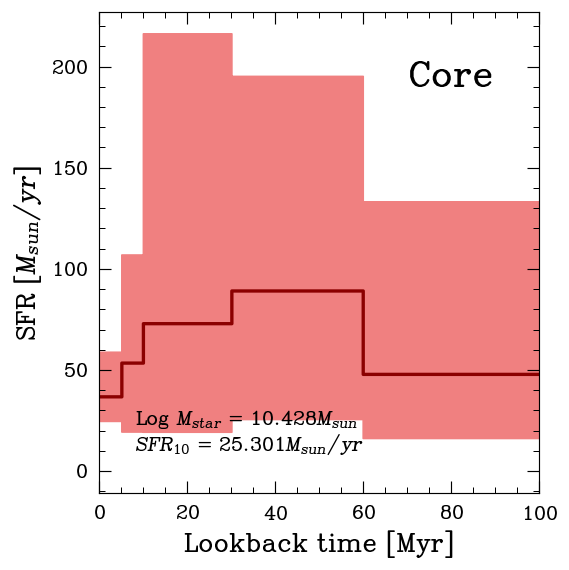

In [ ]:
# Stash SFH data for each component as a dict
sfh_dict = {}
sfh_dict[cname] = {'sfh_t': sfh_t, 
                   'sfh_q50': sfh_q50, 
                   'sfh_q16': sfh_q16, 
                   'sfh_q84': sfh_q84,
                   'stellar_mass': stellar_mass,
                   'sfr)100_Myr': sfr_100_Myr,}
print(sfh_dict.keys())

import smplotlib
fig = plt.figure(figsize=(5, 5))
plt.step(sfh_t*1e3, sfh_q50, where = 'post', color = cmap, lw = 2)
plt.fill_between(sfh_t*1e3, sfh_q16, sfh_q84, color = cmap2, step = 'post')
plt.xlabel('Lookback time [Myr]', fontsize = 18)
plt.ylabel('SFR [$M_{sun}/yr$]', fontsize = 18)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)

plt.xlim(0,100)
plt.text(70, 190, cname, size=size1)
plt.text(8, 23, ( 'Log $M_{star}$ = ' + str(round(math.log10(stellar_mass),3)) + '$M_{sun}$'), fontsize=14) 
plt.text(8, 10, ( '$SFR_{10}$ = ' + str(round(sfr_100_Myr,3)) + '$M_{sun}/yr$'), fontsize = 14)
# plt.title(f'{cname}')
# plt.title('SFH', fontsize = 30)
tight_layout()
# plt.savefig(path_wdir + '/plots/' + output_file.split('.')[0] + '_sfh')